In [1]:
import scanpy as sc
from sklearn.neighbors import NearestNeighbors
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os

In [8]:
basepath = '/stanley/WangLab/kamal/code/remote_notebooks/spin_tests/figures/'
dpi = 300
figsize = (5,6)
s = 10
region_cmap = {str(i):sc.pl.palettes.default_102[i] for i in range(40)}

In [3]:
adata = sc.read_h5ad('/stanley/WangLab/kamal/data/spin_tests/single.h5ad')
adata

AnnData object with n_obs × n_vars = 37928 × 1022
    obs: 'orginindex', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'name', 'mouseID', 'batch', 'cell_center_1', 'cell_center_2', 'cell_center_3', 'CellLabel_rank4', 'x', 'y', 'segment'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'CellLabel_rank4_colors', 'hvg', 'leiden', 'neighbors', 'pca', 'segment', 'umap'
    obsm: 'X_nbr_pca', 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'segment_connectivities', 'segment_distances'

In [4]:
# Get nbrs
def get_nbrs(adata, n_nbrs, spatial_key):
    coordinates = adata.obsm[spatial_key]
    nbrs = NearestNeighbors(n_neighbors=n_nbrs)
    nbrs.fit(coordinates)
    _, nbr_idxs = nbrs.kneighbors(coordinates)
    adata.obsm['nbr_idxs'] = nbr_idxs
    adata.uns['n_nbrs'] = n_nbrs
    adata.uns['spatial_key'] = spatial_key

# Smooth
def smooth(adata):
    X_smooth = np.zeros(adata.X.shape)
    for nth_nbrs in np.array(adata.obsm['nbr_idxs']).T:
        X_smooth += adata.X[nth_nbrs] / adata.uns['n_nbrs']
    adata.layers['smooth'] = X_smooth

# PCA on smooth features
def pca(adata, pca_key='X_pca', n_pcs=50, svd_solver='randomized', random_state=0):
    pca = PCA(n_components=n_pcs, svd_solver=svd_solver, random_state=random_state)
    adata.obsm[pca_key] = pca.fit_transform(adata.layers['smooth'])
    adata.varm[pca_key] = pca.components_.T

In [18]:
x = np.array([
    [1,2,3],
    [4,5,6],
    [1,1,1]
])
np.random.shuffle(x)
x

array([[1, 2, 3],
       [4, 5, 6],
       [1, 1, 1]])

In [5]:
print('Before:')
print(adata.X)
np.random.shuffle(adata.X)
print('After:')
print(adata.X)

Before:
[[-0.20003457 -0.2175461  -0.17486025 ... -0.62254727 -0.2637002
  -0.21777013]
 [-0.2204987  -0.14724006 -0.24140288 ... -0.7934895  -0.2887726
  -0.3717419 ]
 [-0.20477009 -0.20127696 -0.19025853 ... -0.6621041   4.9282107
  -0.25339997]
 ...
 [-0.20865995 -0.18791299 -0.20290715 ... -0.69459736 -0.2742679
  -0.28266734]
 [-0.2123807  -0.17513005 -0.2150058  ... -0.7256777  -0.27882653
  -0.31066218]
 [-0.19724402 -0.2271333   7.3910017  ... -0.59923697 -0.2602812
  -0.19677398]]
After:
[[-0.20477009 -0.20127696 -0.19025853 ... -0.6621041  -0.26950207
  -0.25339997]
 [-0.20104934 -0.21405986 -0.17815988 ...  1.380638   -0.26494342
  -0.2254051 ]
 [-0.20536204 -0.1992433  -0.19218332 ... -0.66704875 -0.2702273
  -0.2578537 ]
 ...
 [-0.2146639  -0.167286   -0.22242998 ...  0.41260105 -0.2816239
  -0.32784086]
 [-0.22168258 -0.14317277 -0.24525245 ...  1.2608658  -0.29022312
  -0.38064936]
 [-0.220245   -0.14811163 -0.24057798 ...  0.8477712  -0.2884618
  -0.36983314]]


In [6]:
n_nbrs = 30
get_nbrs(adata, n_nbrs, 'spatial')
smooth(adata)

# Similarities

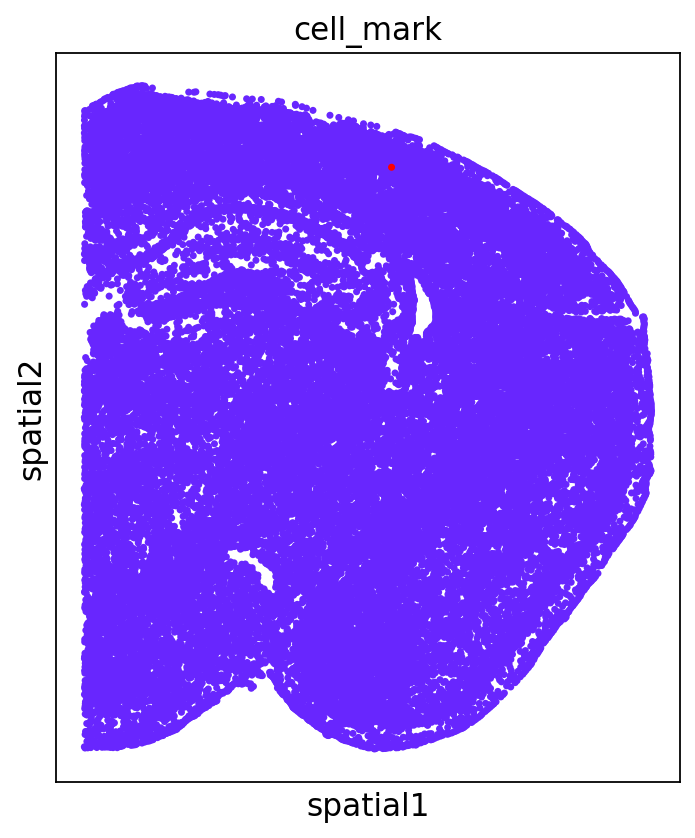

In [9]:
cell_idx = 13009
cell_mark = np.zeros(len(adata))
cell_mark[cell_idx] = 1
adata.obs['cell_mark'] = cell_mark

sc.set_figure_params(figsize=figsize)
sc.pl.embedding(adata, basis='spatial', color='cell_mark', cmap='rainbow', s=40, vmin=-0.05, colorbar_loc=None)

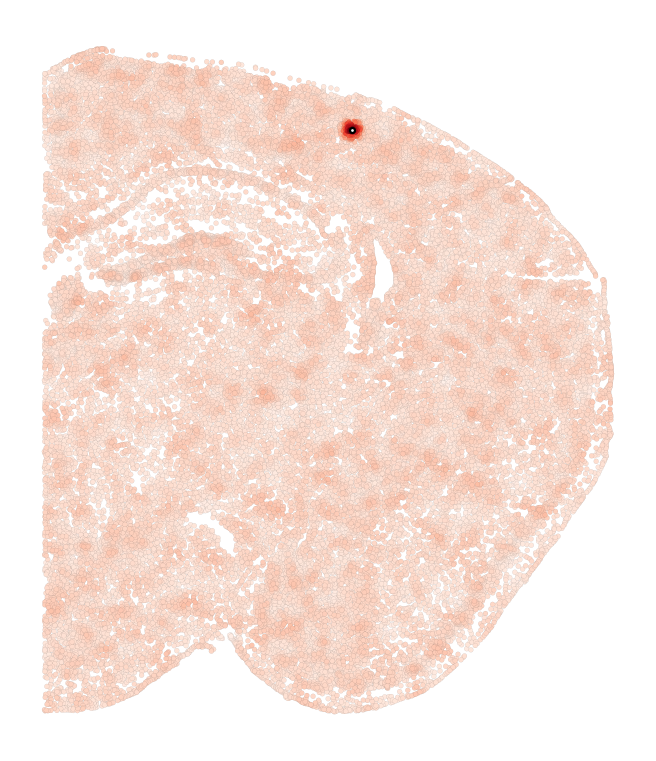

In [12]:
layer = 'smooth'

X = adata.layers[layer].copy()
adata.obs['similarity'] = X[cell_idx] @ X.T
other_cell_idxs = np.where(np.arange(len(adata)) != cell_idx)[0]
subdata = adata[other_cell_idxs]

sc.set_figure_params(figsize=figsize)
sc.pl.embedding(subdata, basis='spatial', color='similarity', cmap='Reds', s=20, colorbar_loc=None, return_fig=True, title='', edgecolor='k', linewidth=0.02)
plt.scatter(*adata[cell_idx].obsm['spatial'].T, color='w', s=5, edgecolor='k')
plt.axis('off')
figname = f'similarity_{layer}_shuffled.png'
savepath = os.path.join(basepath, figname)
plt.savefig(savepath, bbox_inches='tight', transparent=True, dpi=dpi)

In [13]:
k = 15
lim = np.sort(adata.obs['similarity'].values)[::-1][k]
subdata.obs['most_similar'] = subdata.obs['similarity'] >= lim
subdata.obs['most_similar'] = subdata.obs['most_similar'].astype(str)

/local/scratch/38848729.1.interactive/ipykernel_182639/2853408758.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  subdata.obs['most_similar'] = subdata.obs['similarity'] >= lim


In [14]:
x,y = adata.obsm['spatial'][cell_idx]
window = 1000

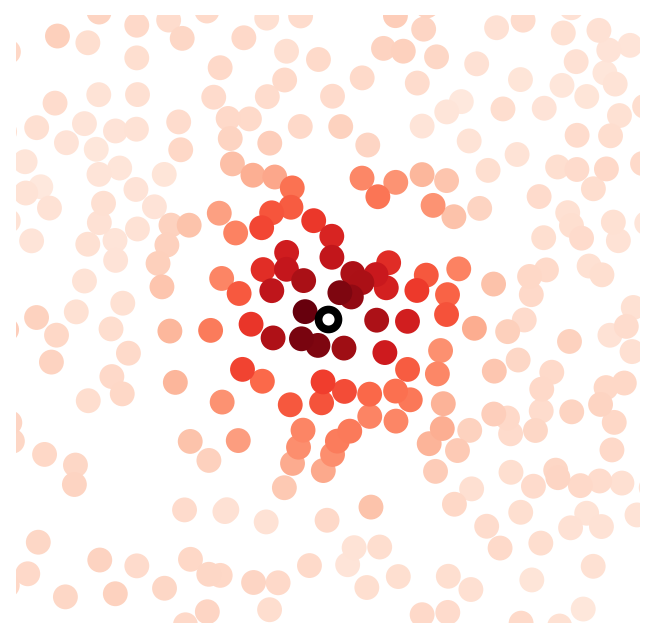

In [15]:
sc.set_figure_params(figsize=(5,5))
sc.pl.embedding(subdata, basis='spatial', color='similarity', cmap='Reds', s=500, colorbar_loc=None, return_fig=True, title='')
plt.scatter(*adata[cell_idx].obsm['spatial'].T, color='w', s=80, edgecolor='k', linewidth=3.5)
plt.axis('off')
plt.xlim(x-window,x+window)
plt.ylim(y-window,y+window)
figname = f'similarity_{layer}_zoom_shuffled.png'
savepath = os.path.join(basepath, figname)
plt.savefig(savepath, bbox_inches='tight', transparent=True, dpi=dpi)

/stanley/WangLab/envs/neighbors/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/stanley/WangLab/envs/neighbors/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


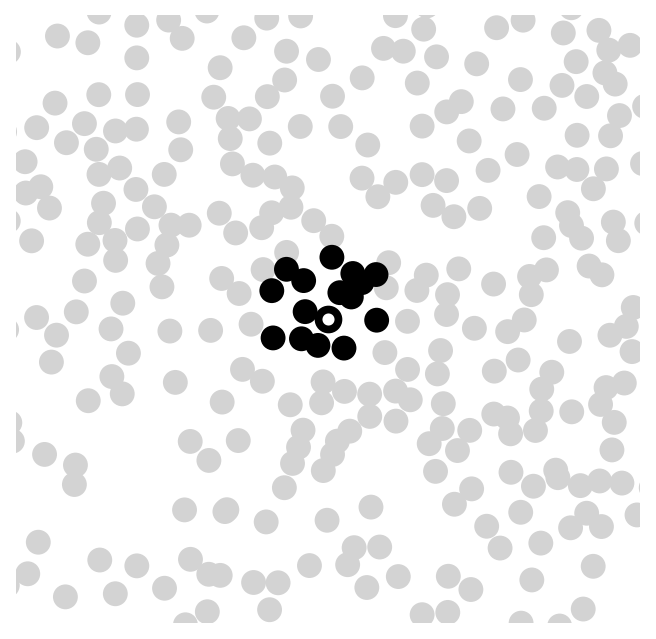

In [16]:
k = 15
sc.set_figure_params(figsize=(5,5))
sc.pl.embedding(subdata, basis='spatial', color='most_similar', groups='True', palette=['k'], s=500, legend_loc=None, return_fig=True, title='')
plt.scatter(*adata[cell_idx].obsm['spatial'].T, color='w', s=80, edgecolor='k', linewidth=3.5)
plt.axis('off')
plt.xlim(x-window,x+window)
plt.ylim(y-window,y+window)
figname = f'most_similar_{layer}_zoom_shuffled.png'
savepath = os.path.join(basepath, figname)
plt.savefig(savepath, bbox_inches='tight', transparent=True, dpi=dpi)

# Clustering

## With PCA

In [23]:
pca(adata)

In [24]:
sc.pp.neighbors(adata)
sc.tl.leiden(adata, resolution=0.2)
sc.tl.umap(adata)

In [34]:
adata.obs['leiden']

index
359677    13
359681    13
359682    13
359683    13
359684    13
          ..
404552     6
404553     6
404555     6
404557     6
404558     6
Name: leiden, Length: 37928, dtype: category
Categories (31, object): ['0', '1', '2', '3', ..., '27', '28', '29', '30']

In [39]:
sc.tl.leiden(adata, resolution=0.12)

In [40]:
adata.obs['leiden']

index
359677    16
359681    16
359682    16
359683    16
359684    16
          ..
404552     9
404553     9
404555     9
404557     9
404558     9
Name: leiden, Length: 37928, dtype: category
Categories (23, object): ['0', '1', '2', '3', ..., '19', '20', '21', '22']

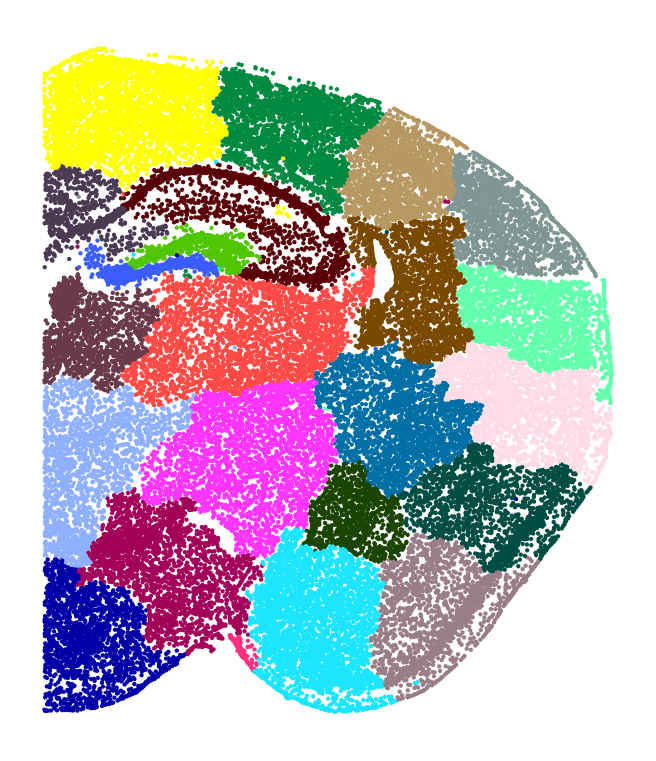

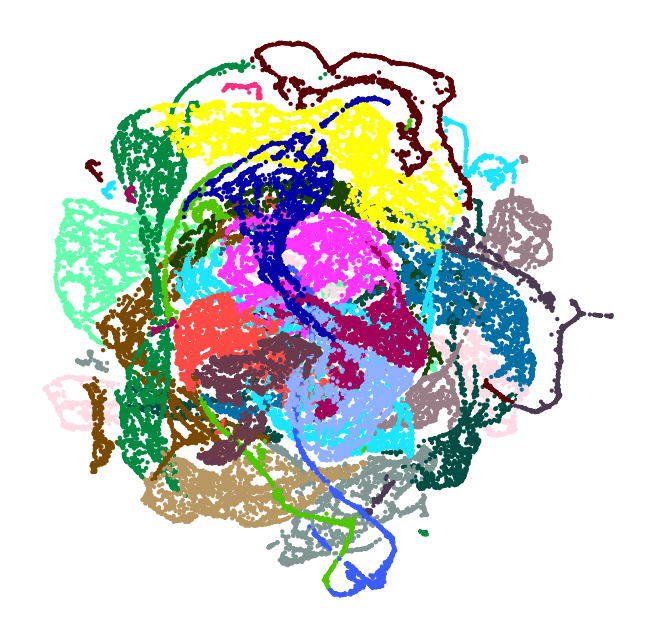

In [41]:
sc.set_figure_params(figsize=(5,6))
sc.pl.embedding(adata, basis='spatial', color='leiden', s=15, palette=sc.pl.palettes.default_102, legend_loc=None, return_fig=True, title='')
plt.axis('off')
figname = f'tissue_smooth_shuffled_leiden.png'
savepath = os.path.join(basepath, figname)
plt.savefig(savepath, bbox_inches='tight', transparent=True, dpi=dpi)

sc.set_figure_params(figsize=(5,5))
sc.pl.embedding(adata, basis='X_umap', color='leiden', s=15, palette=sc.pl.palettes.default_102, legend_loc=None, return_fig=True, title='')
plt.axis('off')
figname = f'umap_smooth_shuffled_leiden.png'
savepath = os.path.join(basepath, figname)
plt.savefig(savepath, bbox_inches='tight', transparent=True, dpi=dpi)

## Without PCA

In [44]:
adata.obsm['smooth'] = adata.layers['smooth']
sc.pp.neighbors(adata, use_rep='smooth')
sc.tl.leiden(adata, resolution=0.1)
sc.tl.umap(adata)

In [45]:
adata.obs['leiden']

index
359677     8
359681    13
359682    13
359683    13
359684     8
          ..
404552    10
404553    10
404555    10
404557    10
404558    10
Name: leiden, Length: 37928, dtype: category
Categories (18, object): ['0', '1', '2', '3', ..., '14', '15', '16', '17']

In [54]:
sc.tl.leiden(adata, resolution=0.16)

In [55]:
adata.obs['leiden']

index
359677     4
359681    19
359682    19
359683    19
359684     4
          ..
404552     8
404553     8
404555     8
404557     8
404558     8
Name: leiden, Length: 37928, dtype: category
Categories (23, object): ['0', '1', '2', '3', ..., '19', '20', '21', '22']

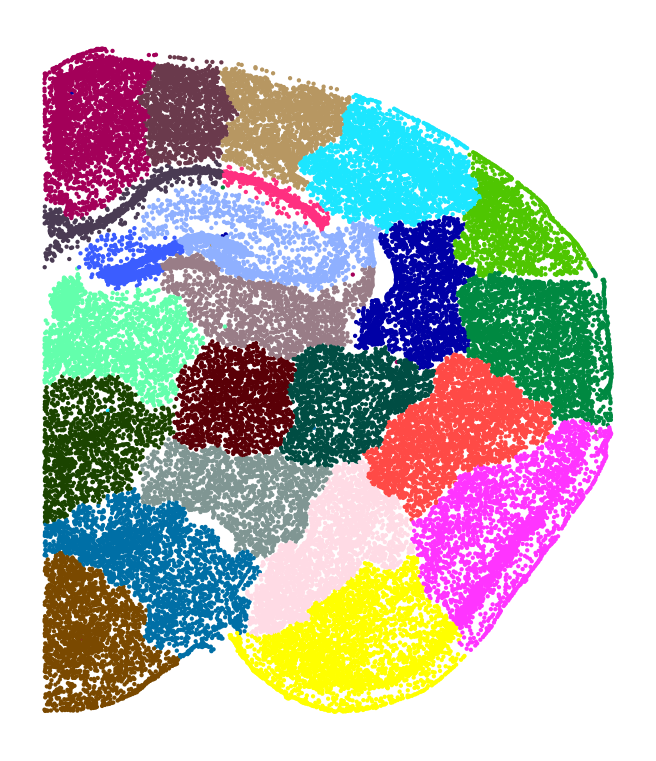

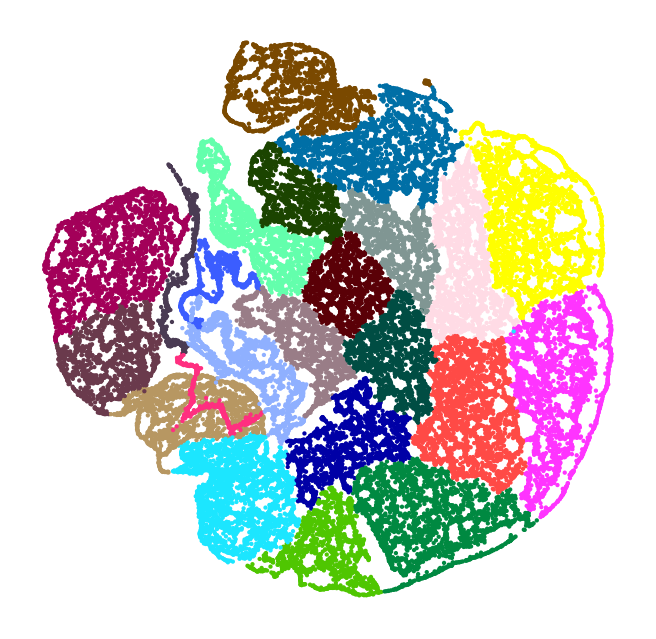

In [56]:
sc.set_figure_params(figsize=(5,6))
sc.pl.embedding(adata, basis='spatial', color='leiden', s=15, palette=sc.pl.palettes.default_102, legend_loc=None, return_fig=True, title='')
plt.axis('off')
figname = f'tissue_smooth_shuffled_leiden_nopca.png'
savepath = os.path.join(basepath, figname)
plt.savefig(savepath, bbox_inches='tight', transparent=True, dpi=dpi)

sc.set_figure_params(figsize=(5,5))
sc.pl.embedding(adata, basis='X_umap', color='leiden', s=15, palette=sc.pl.palettes.default_102, legend_loc=None, return_fig=True, title='')
plt.axis('off')
figname = f'umap_smooth_shuffled_leiden_nopca.png'
savepath = os.path.join(basepath, figname)
plt.savefig(savepath, bbox_inches='tight', transparent=True, dpi=dpi)